# IPL Match Predictor

Given a few parameters such as the teams playing, and maybe even the location of the match, I'll be attempting to predict the winners of the match. But first, not without doing some fun analytics and statistics on the data.

Let's first import the packages necessary for our project.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Now, using the famous pandas library, let's read our CSV and print the first few rows of the dataset while we have it.

In [2]:
matches = pd.read_csv('./matches.csv')
matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Let's clean up the data a bit... I don't like reading such long names, so let's just convert all the team names to their abbreviations for now.

In [3]:
matches.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
         'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
         'Sunrisers Hyderabad','Rising Pune Supergiants','Kochi Tuskers Kerala','Pune Warriors','Rising Pune Supergiant']
        ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW','RPS'], inplace=True)
matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,SRH,RCB,RCB,field,normal,0,SRH,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,MI,RPS,RPS,field,normal,0,RPS,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,GL,KKR,KKR,field,normal,0,KKR,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,RPS,KXIP,KXIP,field,normal,0,KXIP,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,RCB,DD,RCB,bat,normal,0,RCB,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Now that looks much better!

Let's also drop the `umpire3` column as most of the values seem to be NaN (not available).

In [4]:
matches.drop('umpire3', axis=1, inplace=True)

## Basic Analysis of Data

This is just for the fun of it, to analyse and make sense of our data.

In [5]:
print('Total Matches Played:', matches.shape[0])
print('\nVenues Played At:', matches['city'].unique())     
print('\nTeams :', matches['team1'].unique())

Total Matches Played: 636

Venues Played At: ['Hyderabad' 'Pune' 'Rajkot' 'Indore' 'Bangalore' 'Mumbai' 'Kolkata'
 'Delhi' 'Chandigarh' 'Kanpur' 'Jaipur' 'Chennai' 'Cape Town'
 'Port Elizabeth' 'Durban' 'Centurion' 'East London' 'Johannesburg'
 'Kimberley' 'Bloemfontein' 'Ahmedabad' 'Cuttack' 'Nagpur' 'Dharamsala'
 'Kochi' 'Visakhapatnam' 'Raipur' 'Ranchi' 'Abu Dhabi' 'Sharjah' nan]

Teams : ['SRH' 'MI' 'GL' 'RPS' 'RCB' 'KKR' 'DD' 'KXIP' 'CSK' 'RR' 'DC' 'KTK' 'PW']


In [6]:
print('Total venues played at:', matches['city'].nunique())
print('\nTotal umpires:', matches['umpire1'].nunique())

Total venues played at: 30

Total umpires: 44


In [7]:
print((matches['player_of_match'].value_counts()).idxmax(), 'has most man of the match awards')
print(((matches['winner']).value_counts()).idxmax(), 'has the highest number of match wins')

CH Gayle has most man of the match awards
MI has the highest number of match wins


Now, let's look at something more interesting... the tosses. Just by looking at the data, I can see that most of the teams who have won the toss, actually go ahead to win the match itself. But let's verify this presumption with some actual analytics.

In [8]:
matches.groupby(['toss_winner']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)

,toss_winner,counts
7,MI,85
4,KKR,78
2,DD,72
9,RCB,70
6,KXIP,68
0,CSK,66
11,RR,63
1,DC,43
12,SRH,35
8,PW,20


In [9]:
matches.groupby(['winner']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)

,winner,counts
7,MI,92
0,CSK,79
4,KKR,77
9,RCB,73
6,KXIP,70
11,RR,63
2,DD,62
12,SRH,42
1,DC,29
10,RPS,15


Right off the bat, we see that Mumbai Indians has won the highest number of tosses, and also the highest number of matches over all IPL seasons.

## Predicting the Outcome

Let's convert all the team names to unique integers, so it can work well with our machine learning model.

In [10]:
matches['team1'] = matches['team1'].astype('category').cat.codes
matches['team2'] = matches['team2'].astype('category').cat.codes
matches['winner'] = matches['winner'].astype('category').cat.codes

matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2
0,1,2017,Hyderabad,2017-04-05,12,9,RCB,field,normal,0,12,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong
1,2,2017,Pune,2017-04-06,7,10,RPS,field,normal,0,10,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi
2,3,2017,Rajkot,2017-04-07,3,4,KKR,field,normal,0,4,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan
3,4,2017,Indore,2017-04-08,10,6,KXIP,field,normal,0,6,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin
4,5,2017,Bangalore,2017-04-08,9,2,RCB,bat,normal,0,9,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN


In [11]:
features = matches[['team1', 'team2']].values
result = matches['winner'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size=0.3, random_state=0)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.size)
print('y_test:', y_test.size)

X_train: (445, 2)
X_test: (191, 2)
y_train: 445
y_test: 191


### There are 3 steps to setting up any model with sklearn
1. Set up the model
2. Fit the data
3. Make predictions
4. Check the score

Seems simple, right? Let's try it out!

In [41]:
# 1. Set up the model
model = KNeighborsClassifier(n_neighbors=3)

# 2. Fit the data
model.fit(X_train, y_train)

# 3. Make predictions
y_pred = model.predict(X_test)

# 4. Check the score
print('The accuracy of the KNN is', metrics.accuracy_score(y_pred, y_test) * 100)

The accuracy of the KNN is 42.40837696335078


([<matplotlib.axis.XTick at 0x11197e748>,
 <a list of 10 Text xticklabel objects>)

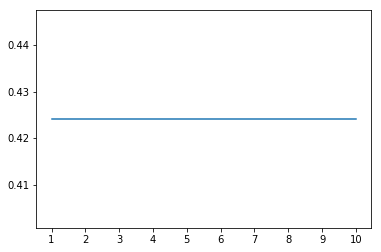

In [47]:
a_index = list(range(1, 11))
a = pd.Series()
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in list(range(1, 11)):
    model = KNeighborsClassifier(n_neighbors=i) 
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    a = a.append(pd.Series(metrics.accuracy_score(y_pred, y_test)))
plt.plot(a_index, a)
plt.xticks(x)

Great! Let's try to make some actual predictions now.

In [65]:
print('In a match between CSK (0) and DC (1), the winner would probably be:',
      model.predict([[0, 1]]))

In a match between CSK (0) and DC (1), the winner would probably be: [0]


It seems like CSK won the probability battle, but wait...

To verify this data, we could take a look at the match history between CSK and DC.

In [73]:
matches.loc[(matches['team1'] == 0) & (matches['team2'] == 1)][['team1', 'team2', 'winner']]

,team1,team2,winner
84,0,1,1
130,0,1,1
143,0,1,0
215,0,1,1
231,0,1,0
271,0,1,0
312,0,1,0
351,0,1,0


As you can see, just as our model predicted, CSK seems to have outranked DC in a majority of matches (5 out of 8). I think it's safe to say that our model is working as expected.

## Conclusion

I hope you liked this notebook that teaches all about the basics of Machine Learning and Classification, in a fun and thought provoking exercise. Please leave any commments in the GitHub repository, or contact me through email. I would be more than happy to reach out. Do contribute to this 